![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
#### Add your code here ####
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [2]:
import numpy as np
data = np.load('/content/drive/MyDrive/ACV-Project-1 Datatset/images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

In [3]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [4]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [5]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [6]:
X.shape

(409, 224, 224, 3)

### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

Training data

Testing data

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,masks,test_size=9,random_state=1)

In [8]:
x_train.shape

(400, 224, 224, 3)

In [9]:
y_train.shape

(400, 224, 224)

In [10]:
x_test.shape

(9, 224, 224, 3)

In [11]:
y_test.shape

(9, 224, 224)

### Print a sample training image, image array and its mask (2 marks)

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


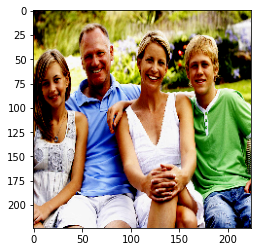

In [12]:
from matplotlib import pyplot as plt
plt.imshow(x_train[0])

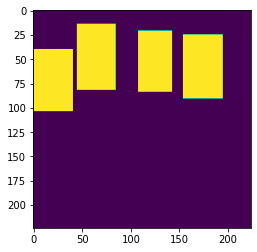

In [13]:
plt.imshow(y_train[0])

In [14]:
x_train[0]

array([[[-0.0745098 , -0.09803921, -0.49019605],
        [-0.15294117, -0.19215685, -0.52156866],
        [-0.19215685, -0.29411763, -0.56078434],
        ...,
        [ 0.70980394,  0.72549021,  0.13725495],
        [ 0.64705884,  0.67058825,  0.04313731],
        [ 0.6156863 ,  0.65490198, -0.0745098 ]],

       [[-0.12156862, -0.16862744, -0.51372552],
        [-0.13725489, -0.21568626, -0.49803919],
        [-0.0745098 , -0.2235294 , -0.45098037],
        ...,
        [ 0.67058825,  0.68627453,  0.11372554],
        [ 0.58431375,  0.60784316, -0.00392157],
        [ 0.51372552,  0.57647061, -0.1607843 ]],

       [[-0.21568626, -0.27058822, -0.56078434],
        [-0.12156862, -0.24705881, -0.49019605],
        [ 0.05882359, -0.12941176, -0.372549  ],
        ...,
        [ 0.63137257,  0.64705884,  0.05882359],
        [ 0.56078434,  0.59215689, -0.06666666],
        [ 0.49803925,  0.52941179, -0.1607843 ]],

       ...,

       [[ 0.65490198,  0.35686278,  0.10588241],
        [ 0

In [15]:
y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Create the model (14 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [16]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras import models,layers

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    #### Add your code here ####
    block0 = model.get_layer("conv_pw_1_relu").output 
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)


### Call the create_model function (4 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [17]:
#### Add your code here ####
model = create_model(False)

### Print model summary (2 mark)

In [18]:
#### Add your code here ####
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Define dice coefficient function (4 marks)
- Create a function to calculate dice coefficient


In [19]:
#### Add your code here ####
def dice_coefficient(y_true,y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)
  return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss function (4 marks)

In [20]:
#### Add your code here ####
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
def loss(y_true,y_pred):
  return binary_crossentropy(y_true,y_pred) - tf.compat.v1.log(dice_coefficient(y_true,y_pred)) + tf.keras.backend.epsilon()

### Compile the model (4 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [34]:
#### Add your code here ####
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4,beta_1=0.9,beta_2=0.09,epsilon=None,decay=0.0)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks (4 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [35]:
#### Add your code here ####
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model_unet_v1.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=10, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [36]:
EPOCHS = 5

In [37]:
history = model.fit(x_train,y_train,epochs=EPOCHS,batch_size=1,verbose=1,callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/5
  1/400 [..............................] - ETA: 21:54 - loss: 0.7070 - dice_coefficient: 0.5456
Epoch 00001: loss improved from inf to 0.70700, saving model to model_unet_v1.h5
  2/400 [..............................] - ETA: 1:17 - loss: 0.8221 - dice_coefficient: 0.4822 
Epoch 00001: loss did not improve from 0.70700
  3/400 [..............................] - ETA: 49s - loss: 1.3624 - dice_coefficient: 0.3620 
Epoch 00001: loss did not improve from 0.70700
  4/400 [..............................] - ETA: 40s - loss: 1.5126 - dice_coefficient: 0.3166
Epoch 00001: loss did not improve from 0.70700
  5/400 [..............................] - ETA: 35s - loss: 1.4588 - dice_coefficient: 0.3252
Epoch 00001: loss did not improve from 0.70700
  6/400 [..............................] - ETA: 32s - loss: 1.5099 - dice_coefficient: 0.3201
Epoch 00001: loss did not improve from 0.70700
  7/400 [..............................] - ETA: 30s - loss: 1.4837 - dice_coefficient: 0.3372
Epoch 00001

### Get the predicted mask for a test image   (5 marks)

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


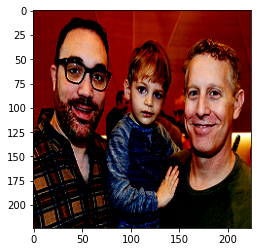

In [38]:
plt.imshow(x_test[2])

Show original mask for test image

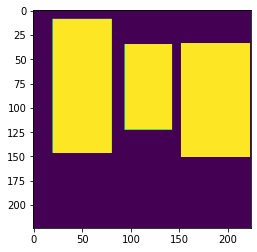

In [39]:
#### Add your code here ####
plt.imshow(y_test[2])

Predict the mask on the test image

In [40]:
WEIGHTS_FILE = "model_unet_v1.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

In [41]:
predicted_masks = model.predict(x_test)

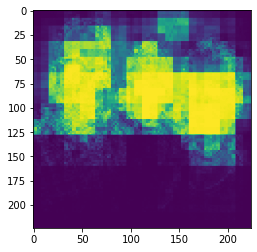

In [42]:
plt.imshow(predicted_masks[2])

### Impose the mask on the test image (5 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


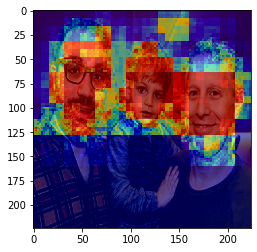

In [43]:
#### Add your code here ####
plt.imshow(x_test[2])
plt.imshow(predicted_masks[2], 'jet', interpolation='none', alpha=0.60)
plt.show()